In [1]:
from lh2pac.gemseo.discipline import H2TurboFan
from lh2pac.gemseo.utils import draw_aircraft
from lh2pac.gemseo.utils import get_aircraft_data
from gemseo.algos.design_space import DesignSpace
from gemseo_mlearning.api import sample_discipline 
from gemseo import configure_logger
from gemseo import create_scenario
from lh2pac.marilib.utils import unit
from numpy import array
from gemseo import create_surrogate
from gemseo.mlearning.quality_measures.r2_measure import R2Measure
from gemseo.mlearning.quality_measures.rmse_measure import RMSEMeasure
from gemseo_mlearning.api import sample_discipline
import pickle
from pathlib import Path
from gemseo import import_discipline

In [2]:
configure_logger()

<RootLogger root (INFO)>

### Définition de la discipline

In [3]:
discipline = H2TurboFan()
discipline.get_input_data_names()
discipline.get_output_data_names()
discipline.default_inputs
discipline.execute()

{'thrust': array([125000.]), 'aspect_ratio': array([9.5]), 'bpr': array([8.5]), 'area': array([160.]), 'tgi': array([0.3]), 'tvi': array([0.845]), 'sfc': array([1.]), 'drag': array([1.]), 'mass': array([1.]), 'vz_mcr': array([1.11425584]), 'coc': array([5790.24820306]), 'far': array([13.14324743]), 'ttc': array([1094.19026816]), 'oei_path': array([0.01700101]), 'mtow': array([84264.87197867]), 'vapp': array([70.64663708]), 'vz_mcl': array([5.53241387]), 'fuel': array([994.73460336]), 'tofl': array([2144.18746791])}

### Analyse des différentes valeurs des variables

In [4]:
aircraft_data = get_aircraft_data(discipline)
print(aircraft_data)

---------------------------------------------------------------------------
Drag factor =    1.000 (0.99 =< kcx =< 1.03)
SFC factor =    1.000 (0.99 =< ksfc =< 1.03)
Mass factor =    1.000 (0.99 =< kmass =< 1.03)
Tank Volumetric Index =    0.845 m3-LH2 / m3-(LH2+Tank), (0.6 =< vi =< 0.85)
Tank Gravimetric Index =    0.300 kg-LH2 / kg-(LH2+Tank), (0.25 =< gi =< 0.305)

Reference thrust =    125.0 kN, (100 =< thrust =< 150)
By Pass Ratio =      8.5 (5 =< bpr =< 12)
Reference area =    160.0 m2, (120 =< area =< 200)
Aspect ratio =      9.5 (7 =< ar =< 12)
---------------------------------------------------------------------------
Criterion, Max Take Off Weight =  84264.9 kg
Criterion, Cost mission fuel block =    994.7 kg
Criterion, Cash Operating Cost =   5790.2 $/trip

Constraint, Take Off Field Length =   2144.2 m (must be =< 2200 m)
Constraint, Approach speed =    137.3 kt (must be =< 137 kt)
Constraint, Vertical speed, MCL rating, TOC =   1089.1 ft/min (must be >= 300 ft/min)
Constra

### Définition de l'espace de design

In [5]:
class MyDesignSpace(DesignSpace):
    def __init__(self):
        super().__init__(name="foo")
        self.add_variable("thrust", l_b=unit.N_kN(100), u_b=unit.N_kN(150), value=array([unit.N_kN(125)]))
        self.add_variable("bpr", l_b=5, u_b=12,value=array([8.5]))
        self.add_variable("area", l_b=120, u_b=200,value=array([160]))
        self.add_variable("aspect_ratio", l_b=7, u_b=12,value=array([9.5]))

In [6]:
design_space = MyDesignSpace()
design_space

Name,Lower bound,Value,Upper bound,Type
thrust,100000,125000,150000,float
bpr,5,8.5,12,float
area,120,160,200,float
aspect_ratio,7,9.5,12,float


### Définition et optimisation du modèle complet 

In [7]:
def complete_model():
    #Define the discipline
    discipline = H2TurboFan()
    #Define the design space
    design_space = MyDesignSpace()
    disciplines = [discipline]
    #Create the scenario to optimize
    scenario = create_scenario(
        disciplines, "DisciplinaryOpt", "mtow", design_space
    )
    #Add the constraints of the model
    scenario.add_constraint("tofl", constraint_type="ineq", positive=False, value=2220)
    scenario.add_constraint("vapp", constraint_type="ineq", positive=False, value=unit.mps_kt(137))
    scenario.add_constraint("vz_mcl", constraint_type="ineq", positive=True, value=unit.mps_ftpmin(300))
    scenario.add_constraint("vz_mcr", constraint_type="ineq", positive=True, value=0+1e-6)
    scenario.add_constraint("oei_path", constraint_type="ineq", positive=True, value=0.011)
    scenario.add_constraint("ttc", constraint_type="ineq", positive=False, value= unit.s_min(25))
    scenario.add_constraint("far", constraint_type="ineq", positive=False, value=13.4)
    #Execute the scenario (optimization step)
    scenario.execute({"algo": "NLOPT_COBYLA", "max_iter": 100})
    #Plot the results of the optimization
    scenario.post_process("OptHistoryView", save=False, show=True)
    return discipline

    INFO - 18:15:30:  
    INFO - 18:15:30: *** Start MDOScenario execution ***
    INFO - 18:15:30: MDOScenario
    INFO - 18:15:30:    Disciplines: H2TurboFan
    INFO - 18:15:30:    MDO formulation: DisciplinaryOpt
    INFO - 18:15:30: Optimization problem:
    INFO - 18:15:30:    minimize mtow(thrust, bpr, area, aspect_ratio)
    INFO - 18:15:30:    with respect to area, aspect_ratio, bpr, thrust
    INFO - 18:15:30:    subject to constraints:
    INFO - 18:15:30:       tofl(thrust, bpr, area, aspect_ratio) <= 2220
    INFO - 18:15:30:       vapp(thrust, bpr, area, aspect_ratio) <= 70.47888888888889
    INFO - 18:15:30:       vz_mcl(thrust, bpr, area, aspect_ratio) >= 1.524
    INFO - 18:15:30:       vz_mcr(thrust, bpr, area, aspect_ratio) >= 1e-06
    INFO - 18:15:30:       oei_path(thrust, bpr, area, aspect_ratio) >= 0.011
    INFO - 18:15:30:       ttc(thrust, bpr, area, aspect_ratio) <= 1500.0
    INFO - 18:15:30:       far(thrust, bpr, area, aspect_ratio) <= 13.4
    INFO - 18

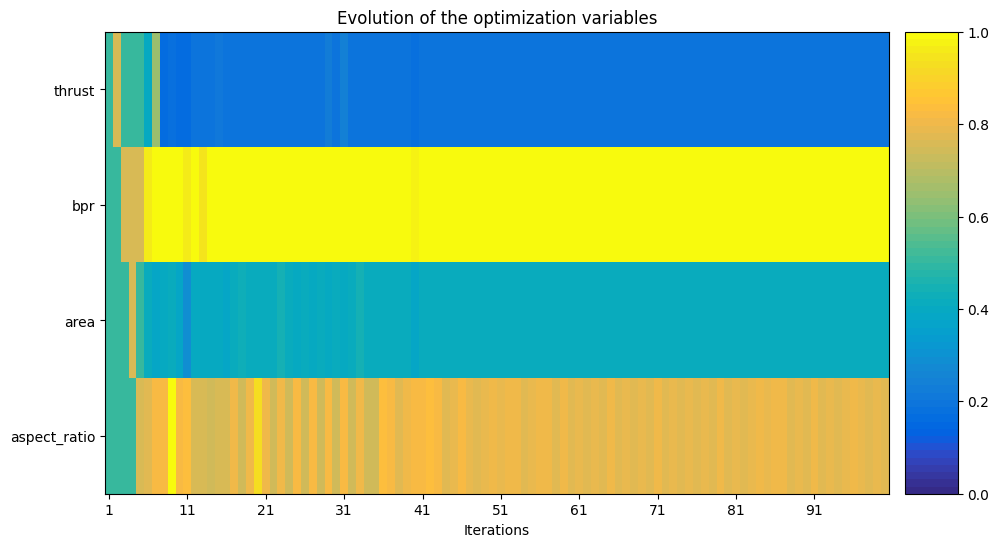

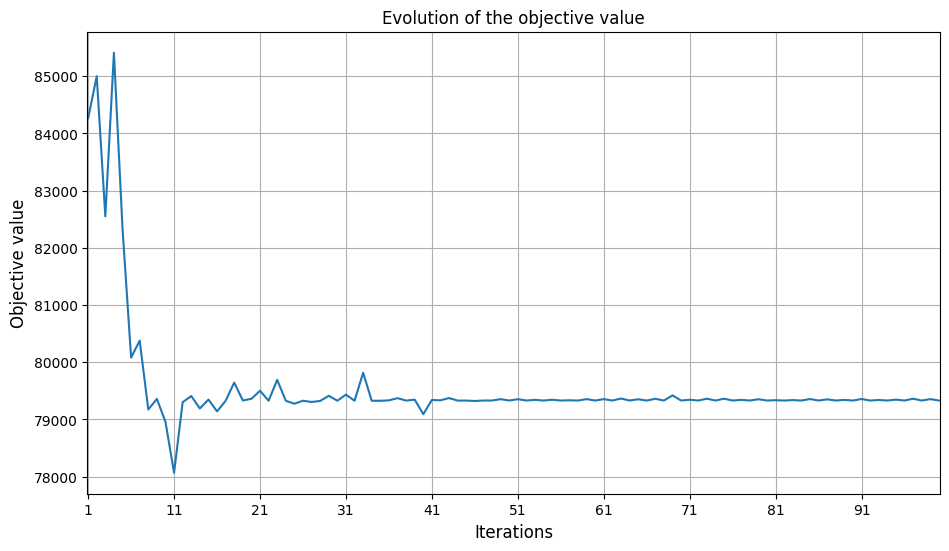

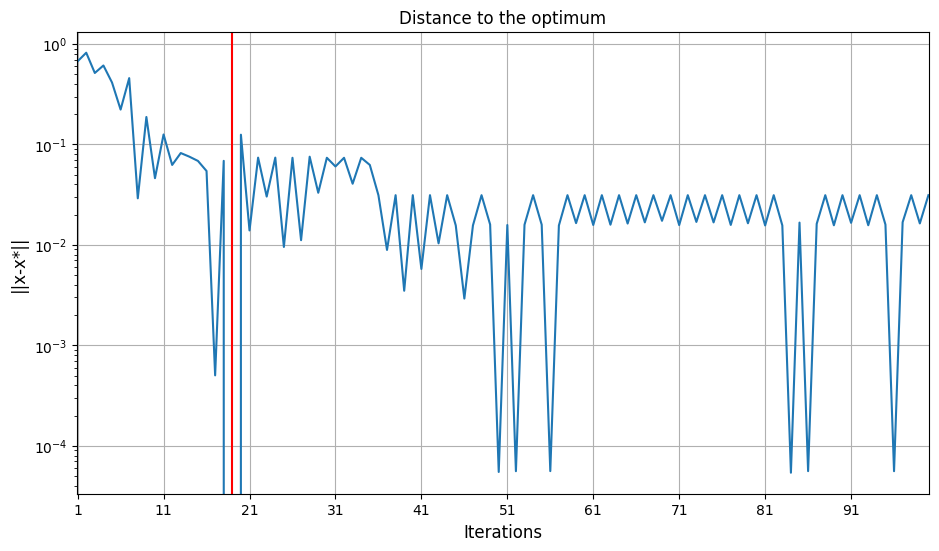

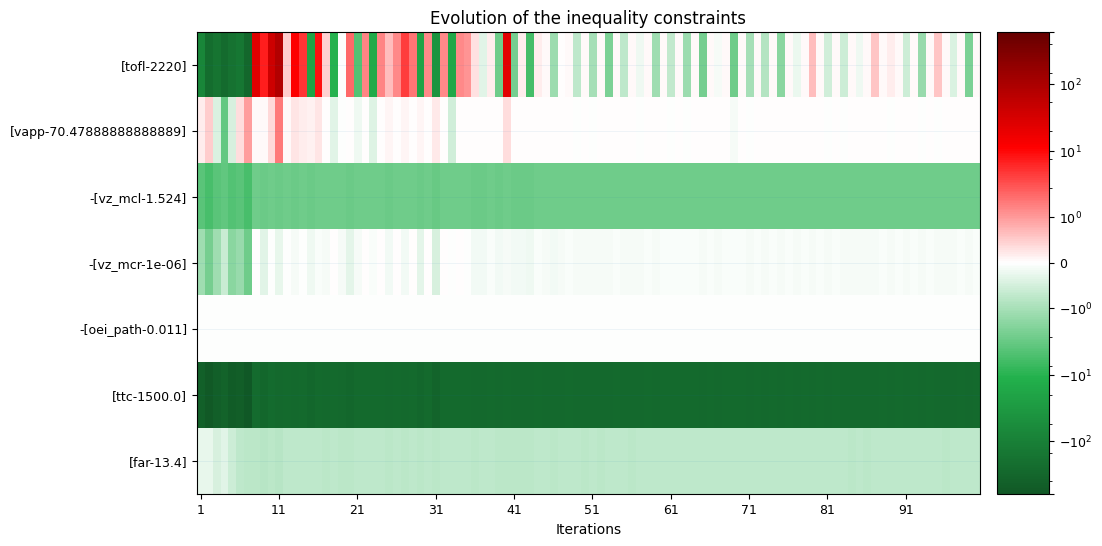

H2TurboFan
   Inputs: area, aspect_ratio, bpr, drag, mass, sfc, tgi, thrust, tvi
   Outputs: coc, far, fuel, mtow, oei_path, tofl, ttc, vapp, vz_mcl, vz_mcr

In [8]:
complete_model()

### Construction et optimisation du modèle de substitution

In [9]:
def surrogate_model(discipline, design_space, name_pickle, sensitivity_analysis=False):
    #Create the dataset 
    dataset = sample_discipline(discipline, design_space, ["mtow","tofl", "vapp", 'vz_mcl', 'vz_mcr', 'oei_path', 'ttc', 'far'], "OT_OPT_LHS", 30)
    #Create the surrogate model and do the optimization process
    surrogate_discipline = create_surrogate('RBFRegressor',epsilon=0.1, function='multiquadric', data=dataset)
    surrogate_discipline.execute({"x": array([1.0])})
    surrogate_discipline.cache.last_entry
    #Compute the R2 criterion
    r2 = R2Measure(surrogate_discipline.regression_model, True)
    print(r2.compute_learning_measure())
    print(r2.compute_cross_validation_measure())
    print("mean value of R2 criterion : ", r2.compute_cross_validation_measure().mean())
    #Compute the RMSE
    rmse = RMSEMeasure(surrogate_discipline.regression_model, True)
    print("rmse :", rmse.compute_learning_measure())
    print("rmse : ", rmse.compute_cross_validation_measure())
    #Store the results in a file 
    with Path(name_pickle).open("wb") as f:
        pickle.dump(surrogate_discipline, f)

    discipline_surr= import_discipline(name_pickle)
    discipline_surr.execute({"x": array([1.0])})
    discipline_surr.get_output_data()

    #Create the scenario
    scenario = create_scenario(
    discipline_surr, "DisciplinaryOpt", "mtow", design_space
    )
    if sensitivity_analysis is False: 
        #Add the constraints
        scenario.add_constraint("tofl", constraint_type="ineq", positive=False, value=2200)
        scenario.add_constraint("vapp", constraint_type="ineq", positive=False, value=unit.mps_kt(137))
        scenario.add_constraint("vz_mcl", constraint_type="ineq", positive=True, value=unit.mps_ftpmin(300))
        scenario.add_constraint("vz_mcr", constraint_type="ineq", positive=True, value=0+1e-6)
        scenario.add_constraint("oei_path", constraint_type="ineq", positive=True, value=0.011)
        scenario.add_constraint("ttc", constraint_type="ineq", positive=False, value= unit.s_min(25))
        scenario.add_constraint("far", constraint_type="ineq", positive=False, value=13.4)
        scenario.execute({"algo": "NLOPT_COBYLA", "max_iter": 100})
        scenario.post_process("OptHistoryView", save=False, show=True)
        #Get the optimized variables and put them in the model in order to see if they satisfy the constraints
        discipline.execute(scenario.optimization_result.x_opt_as_dict)
        print(get_aircraft_data(discipline))
    return discipline_surr, discipline

##### Optimisation du modèle de substitution sous les paramètres de design

    INFO - 18:17:15:  
    INFO - 18:17:15: *** Start DOEScenario execution ***
    INFO - 18:17:15: DOEScenario
    INFO - 18:17:15:    Disciplines: H2TurboFan
    INFO - 18:17:15:    MDO formulation: DisciplinaryOpt
    INFO - 18:17:15: Optimization problem:
    INFO - 18:17:15:    minimize mtow(thrust, bpr, area, aspect_ratio)
    INFO - 18:17:15:    with respect to area, aspect_ratio, bpr, thrust
    INFO - 18:17:15:    over the design space:
    INFO - 18:17:15:       +--------------+-------------+--------+-------------+-------+
    INFO - 18:17:15:       | Name         | Lower bound | Value  | Upper bound | Type  |
    INFO - 18:17:15:       +--------------+-------------+--------+-------------+-------+
    INFO - 18:17:15:       | thrust       |    100000   | 125000 |    150000   | float |
    INFO - 18:17:15:       | bpr          |      5      |  8.5   |      12     | float |
    INFO - 18:17:15:       | area         |     120     |  160   |     200     | float |
    INFO - 18:1

[1. 1. 1. 1. 1. 1. 1. 1.]
[0.91832397 0.92558979 0.94925747 0.54977856 0.77035828 0.95261311
 0.94521605 0.94015817]
mean value of R2 criterion :  0.8700879019260479
rmse : [1.07563748e-15 5.94079451e-12 4.10663191e-18 1.02528469e-12
 4.76491181e-13 2.59453523e-15 8.77005919e-16 1.19979877e-15]
rmse :  [1.21378555e-01 1.21323055e+03 1.86506630e-03 4.53496372e+02
 1.69953356e+02 8.97450180e-01 4.28682790e-01 4.57072062e-01]


    INFO - 18:17:49:    100%|██████████| 100/100 [00:00<00:00, 104.42 it/sec, obj=7.97e+4]
    INFO - 18:17:49: Optimization result:
    INFO - 18:17:49:    Optimizer info:
    INFO - 18:17:49:       Status: None
    INFO - 18:17:49:       Message: Maximum number of iterations reached. GEMSEO Stopped the driver
    INFO - 18:17:49:       Number of calls to the objective function by the optimizer: 102
    INFO - 18:17:49:    Solution:
    INFO - 18:17:49:       The solution is feasible.
    INFO - 18:17:49:       Objective: 79658.588255885
    INFO - 18:17:49:       Standardized constraints:
    INFO - 18:17:49:          -[oei_path-0.011] = -0.005376603749178716
    INFO - 18:17:49:          -[vz_mcl-1.524] = -2.9176339172593435
    INFO - 18:17:49:          -[vz_mcr-1e-06] = -0.13924371242623537
    INFO - 18:17:49:          [far-13.4] = -0.7194104565733834
    INFO - 18:17:49:          [tofl-2200] = 8.54176528264361e-05
    INFO - 18:17:49:          [ttc-1500.0] = -272.8775363450645
 

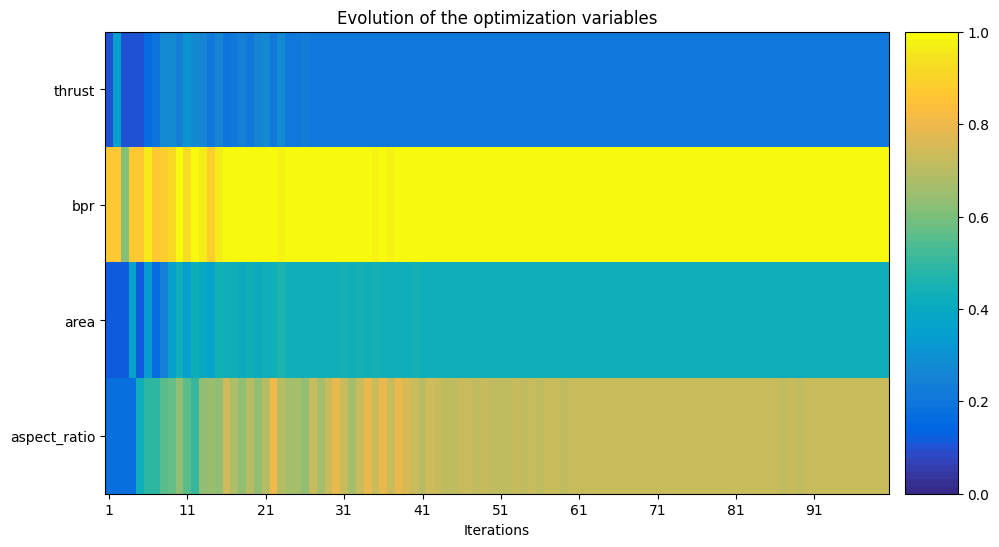

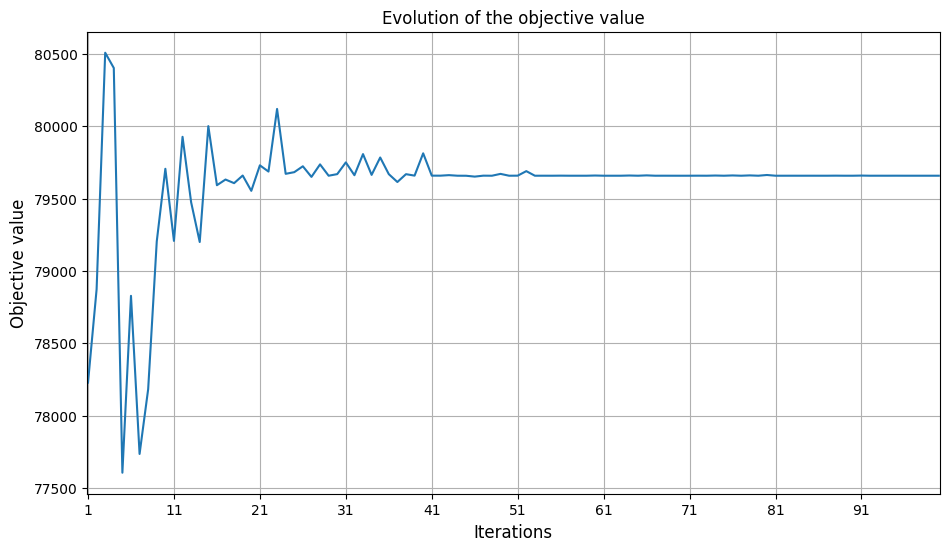

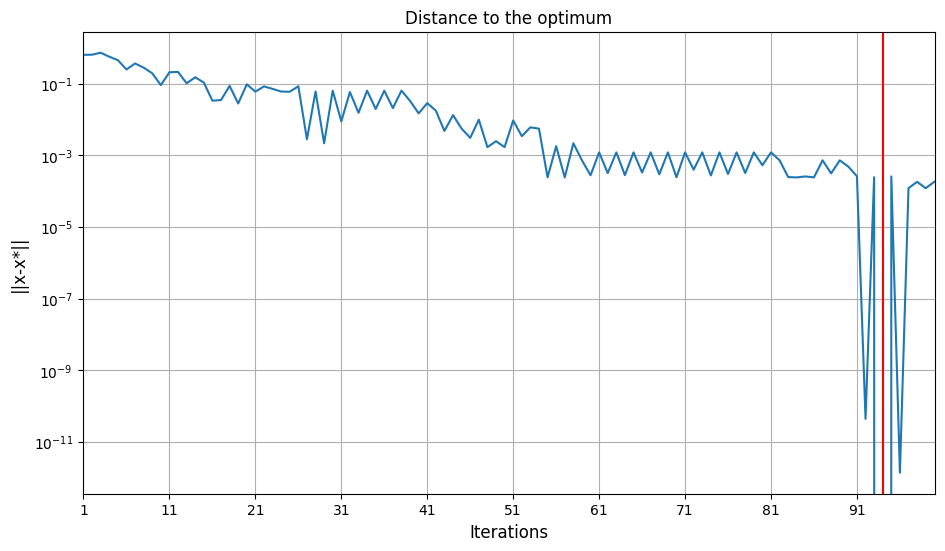

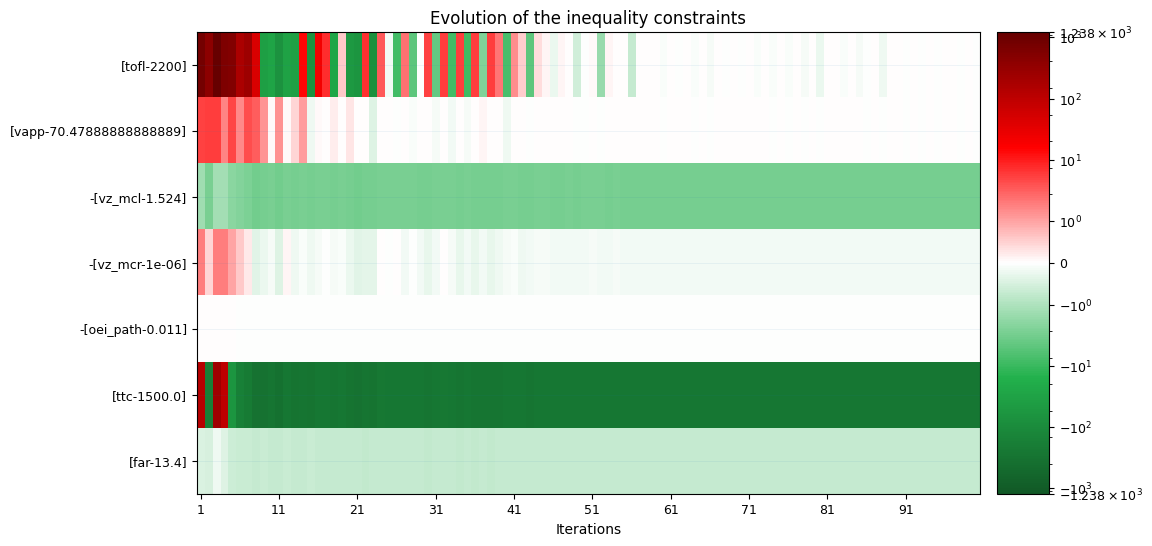

---------------------------------------------------------------------------
Drag factor =    1.000 (0.99 =< kcx =< 1.03)
SFC factor =    1.000 (0.99 =< ksfc =< 1.03)
Mass factor =    1.000 (0.99 =< kmass =< 1.03)
Tank Volumetric Index =    0.845 m3-LH2 / m3-(LH2+Tank), (0.6 =< vi =< 0.85)
Tank Gravimetric Index =    0.300 kg-LH2 / kg-(LH2+Tank), (0.25 =< gi =< 0.305)

Reference thrust =    110.7 kN, (100 =< thrust =< 150)
By Pass Ratio =     12.0 (5 =< bpr =< 12)
Reference area =    154.4 m2, (120 =< area =< 200)
Aspect ratio =     10.6 (7 =< ar =< 12)
---------------------------------------------------------------------------
Criterion, Max Take Off Weight =  79660.9 kg
Criterion, Cost mission fuel block =    857.2 kg
Criterion, Cash Operating Cost =   5725.7 $/trip

Constraint, Take Off Field Length =   2192.7 m (must be =< 2200 m)
Constraint, Approach speed =    136.5 kt (must be =< 137 kt)
Constraint, Vertical speed, MCL rating, TOC =    854.3 ft/min (must be >= 300 ft/min)
Constra

In [10]:
#Create the discipline
discipline_for_surrogate = H2TurboFan()
#Define the design space
design_space = MyDesignSpace()
_, discipline_surr = surrogate_model(discipline=discipline_for_surrogate, design_space=design_space, name_pickle="my_surrogate.pkl")

### Analyse de sensibilité

##### Analyse de Sobol sur le modèle complet 

In [13]:
import pprint
from gemseo.algos.parameter_space import ParameterSpace
from gemseo.uncertainty.sensitivity.sobol.analysis import SobolAnalysis
from gemseo.uncertainty.sensitivity.morris.analysis import MorrisAnalysis


In [15]:
class MyUncertainSpace(ParameterSpace):
    def __init__(self):
        super().__init__()
        self.add_random_variable(
            "tgi", "OTTriangularDistribution", minimum=0.25, mode=0.3, maximum=0.305
        )
        self.add_random_variable(
            "tvi", "OTTriangularDistribution", minimum=0.8, mode=0.845, maximum=0.85
        )
        self.add_random_variable(
            "drag", "OTTriangularDistribution", minimum=0.99, mode=1, maximum=1.03
        )
        self.add_random_variable(
            "sfc", "OTTriangularDistribution", minimum=0.99, mode=1, maximum=1.03
        )
        self.add_random_variable(
            "mass", "OTTriangularDistribution", minimum=0.99, mode=1, maximum=1.03
        )


In [14]:
discipline = H2TurboFan()
uncertain_space = MyUncertainSpace()

In [ ]:
def Sensitivity_analysis(discipline, uncertain_space):
    sobol = SobolAnalysis([discipline], uncertain_space, 100)
    sobol.compute_indices()
    pprint.pprint(sobol.first_order_indices)
    pprint.pprint(sobol.total_order_indices)
    sobol.plot("mtow", save=False, show=True)

In [ ]:
Sensitivity_analysis(discipline, uncertain_space)

#### Analyse de Sobol sur le modèle de substition

In [ ]:
discipline_surr = H2TurboFan()
design_space_surr = MyUncertainSpace()
discipline_surr, _ = surrogate_model(discipline_surr, design_space_surr, name_pickle = "surrogate_sensitivity_analysis.pkl", sensitivity_analysis=True)
Sensitivity_analysis(discipline_surr, uncertain_space)

### Analyse de Morris

In [ ]:
def Morris_analysis(discipline, design_space):
    analysis = MorrisAnalysis([discipline], design_space, n_samples=10000)
    indices = analysis.compute_indices()
    pprint.pprint(analysis.indices)
    analysis.plot("mtow", save=False, show=True, lower_mu=0, lower_sigma=0)
    None

#### Analyse de Morris sur le modèle complet 

In [ ]:
Morris_analysis(discipline, design_space)

#### Analyse de Morris sur le modèle de substitution 

In [ ]:
Morris_analysis(discipline_surr, design_space_surr)

#### Optimisation robuste du modèle de substitution



In [30]:
from gemseo_umdo.scenarios.umdo_scenario import UMDOScenario 

In [31]:
class MySpace(DesignSpace):
    def __init__(self):
        super().__init__(name="foo")
        self.add_variable("thrust", l_b=unit.N_kN(100), u_b=unit.N_kN(150), value=array([unit.N_kN(125)]))
        self.add_variable("bpr", l_b=5, u_b=12,value=array([8.5]))
        self.add_variable("area", l_b=120, u_b=200,value=array([160]))
        self.add_variable("aspect_ratio", l_b=7, u_b=12,value=array([9.5]))
        self.add_variable("tgi",  l_b=0.25, u_b=0.305)
        self.add_variable("tvi", l_b=0.8, u_b=0.85)
        self.add_variable("drag", l_b=0.99, u_b=1.03)
        self.add_variable("sfc",  l_b=0.99, u_b=1.03)
        self.add_variable("mass",  l_b=0.99,  u_b=1.03)

input_space = MySpace()


In [32]:
discipline_surr = H2TurboFan()
discipline_surr, discipline = surrogate_model(discipline_surr, input_space, name_pickle = "surrogate_robust.pkl", sensitivity_analysis=True)

    INFO - 18:36:55:  
    INFO - 18:36:55: *** Start DOEScenario execution ***
    INFO - 18:36:55: DOEScenario
    INFO - 18:36:55:    Disciplines: H2TurboFan
    INFO - 18:36:55:    MDO formulation: DisciplinaryOpt
    INFO - 18:36:55: Optimization problem:
    INFO - 18:36:55:    minimize mtow(thrust, bpr, area, aspect_ratio, tgi, tvi, drag, sfc, mass)
    INFO - 18:36:55:    with respect to area, aspect_ratio, bpr, drag, mass, sfc, tgi, thrust, tvi
    INFO - 18:36:55:    over the design space:
    INFO - 18:36:55:       +--------------+-------------+--------+-------------+-------+
    INFO - 18:36:55:       | Name         | Lower bound | Value  | Upper bound | Type  |
    INFO - 18:36:55:       +--------------+-------------+--------+-------------+-------+
    INFO - 18:36:55:       | thrust       |    100000   | 125000 |    150000   | float |
    INFO - 18:36:55:       | bpr          |      5      |  8.5   |      12     | float |
    INFO - 18:36:55:       | area         |     12

[1. 1. 1. 1. 1. 1. 1. 1.]
[0.77595296 0.78879842 0.84473232 0.5826721  0.59528643 0.85513698
 0.84936409 0.84005262]
mean value of R2 criterion :  0.7284817588709073
rmse : [8.58061873e-16 5.31360815e-12 4.48572407e-18 7.72178320e-13
 5.57336122e-13 2.59453523e-15 1.01125819e-15 1.32395417e-15]
rmse :  [2.36185711e-01 2.51966321e+03 3.30753598e-03 4.84889002e+02
 3.52140325e+02 1.75206221e+00 7.21268288e-01 7.59885557e-01]


In [33]:
design_space = MyDesignSpace()
uncertain_space = MyUncertainSpace()

    INFO - 18:37:31:  
    INFO - 18:37:31: *** Start UMDOScenario execution ***
    INFO - 18:37:31: UMDOScenario
    INFO - 18:37:31:    Disciplines: RBF_H2TurboFan
    INFO - 18:37:31:    Formulation:
    INFO - 18:37:31:       MDO formulation: DisciplinaryOpt
    INFO - 18:37:31:       Statistic estimation: Sampling
    INFO - 18:37:31:    Uncertain space:
    INFO - 18:37:31:       +------+-----------------------------------------------+
    INFO - 18:37:31:       | Name |                  Distribution                 |
    INFO - 18:37:31:       +------+-----------------------------------------------+
    INFO - 18:37:31:       | tgi  | Triangular(lower=0.25, mode=0.3, upper=0.305) |
    INFO - 18:37:31:       | tvi  | Triangular(lower=0.8, mode=0.845, upper=0.85) |
    INFO - 18:37:31:       | drag |   Triangular(lower=0.99, mode=1, upper=1.03)  |
    INFO - 18:37:31:       | sfc  |   Triangular(lower=0.99, mode=1, upper=1.03)  |
    INFO - 18:37:31:       | mass |   Triangular(

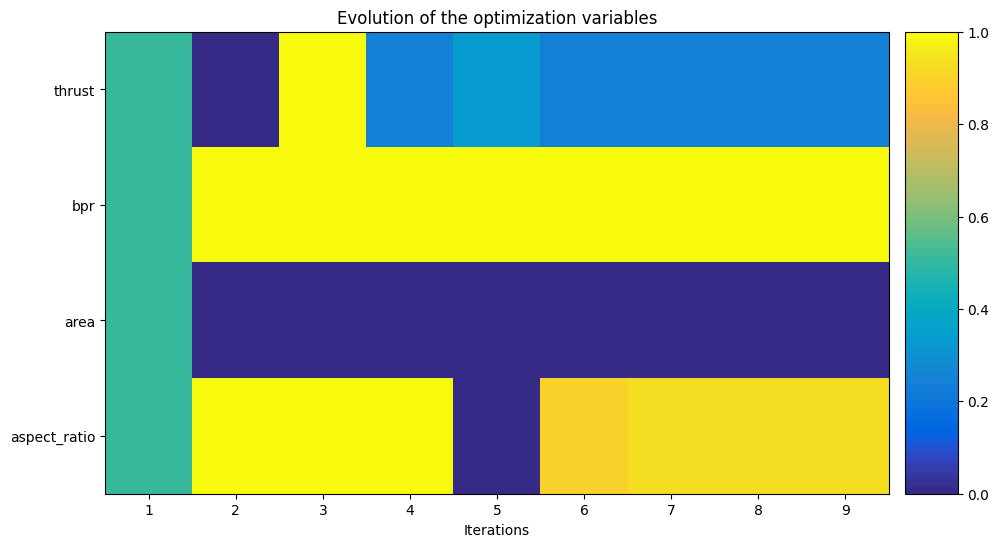

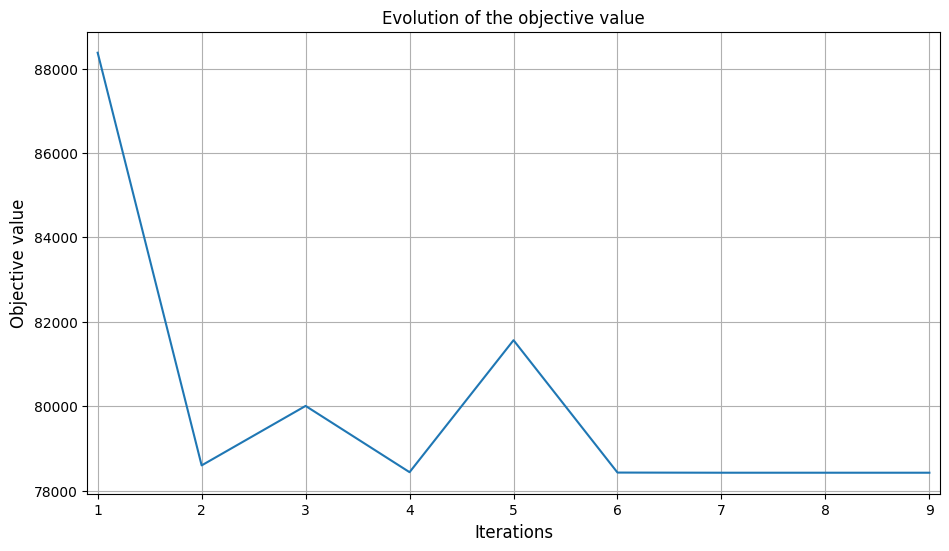

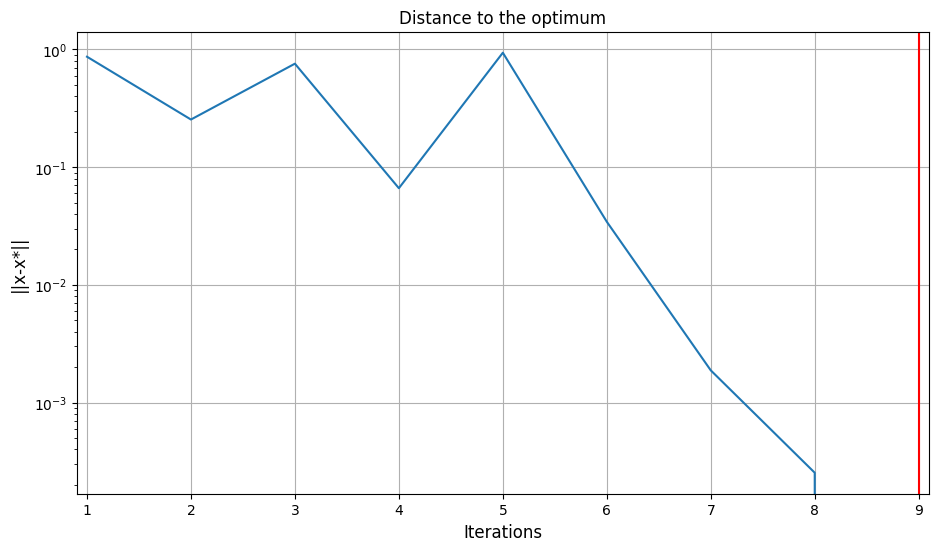

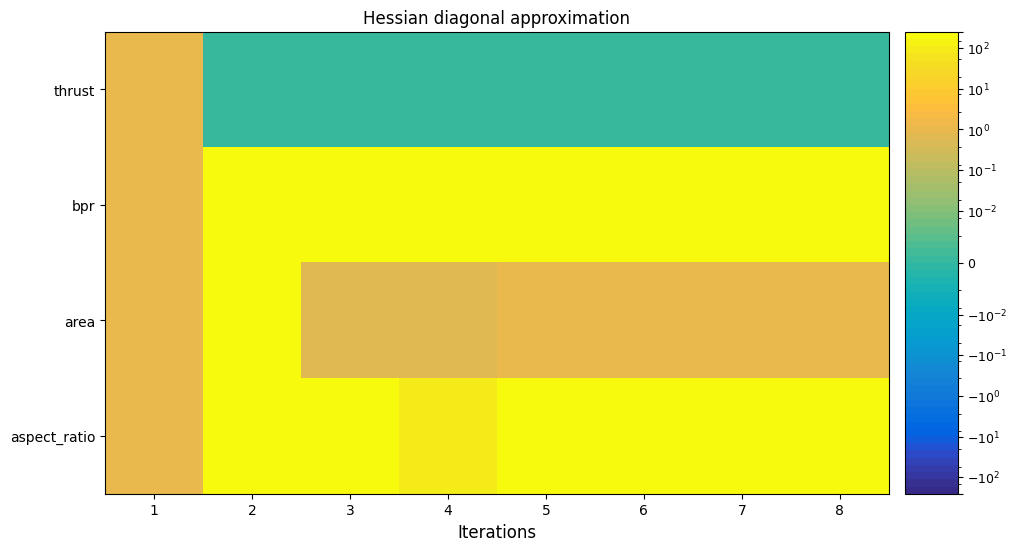

In [34]:
scenario = UMDOScenario(
    [discipline_surr],
    "DisciplinaryOpt",
    "mtow",
    design_space,
    uncertain_space,
    "Mean",
    statistic_estimation="Sampling",  ## Monte Carlo
    statistic_estimation_parameters={"n_samples": 100},
)

scenario.set_differentiation_method("finite_differences")
scenario.execute({"algo": "NLOPT_SLSQP", "max_iter": 1000})
scenario.post_process("OptHistoryView", save=False, show=True)